In [1]:
from string import ascii_letters

import pandas as pd
from pandas.api.types import is_numeric_dtype


import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

import seaborn as sns

from scipy.stats import norm, ranksums, mannwhitneyu, shapiro, probplot, ttest_ind, pointbiserialr, spearmanr, pearsonr,\
chi2_contingency

import pingouin as pg
import statsmodels.api as sm

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.6, the latest is 0.3.7.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
from tqdm import tqdm_notebook
import time

In [3]:
import sys

In [4]:
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 200

In [5]:
%cd "C:\Users\Alex\Desktop\Ryerson - Data Science\Spring 2020\MRP Course\Dataset\"

C:\Users\Alex\Desktop\Ryerson - Data Science\Spring 2020\MRP Course\Dataset


# Load Files to Dataframe

In [6]:
fileList = !ls
dfList = []
fileCount = 0

for file in fileList:
    df = pd.read_csv(file)
    dfList.append(df)
    fileCount += 1
    #print ("Processed file: ", fileCount)
    print('Processed File: {:d} - {}'.format(fileCount, file))

dfFullLoans = pd.concat(dfList, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Processed File: 1 - LoanStats_securev1_2016Q1.csv
Processed File: 2 - LoanStats_securev1_2016Q2.csv


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (19,59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Processed File: 3 - LoanStats_securev1_2016Q3.csv
Processed File: 4 - LoanStats_securev1_2016Q4.csv


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (118) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Processed File: 5 - LoanStats_securev1_2017Q1.csv
Processed File: 6 - LoanStats_securev1_2017Q2.csv
Processed File: 7 - LoanStats_securev1_2017Q3.csv
Processed File: 8 - LoanStats_securev1_2017Q4.csv
Processed File: 9 - LoanStats_securev1_2018Q1.csv
Processed File: 10 - LoanStats_securev1_2018Q2.csv
Processed File: 11 - LoanStats_securev1_2018Q3.csv
Processed File: 12 - LoanStats_securev1_2018Q4.csv
Processed File: 13 - LoanStats_securev1_2019Q1.csv


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (144,145,146) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Processed File: 14 - LoanStats_securev1_2019Q2.csv
Processed File: 15 - LoanStats_securev1_2019Q3.csv
Processed File: 16 - LoanStats_securev1_2019Q4.csv
Processed File: 17 - LoanStats3a_securev1.csv


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (129,130,131,134,135,136,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Processed File: 18 - LoanStats3b_securev1.csv


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (19,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Processed File: 19 - LoanStats3c_securev1.csv


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (19,49,59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Processed File: 20 - LoanStats3d_securev1.csv


In [7]:
dfFullLoans.shape

(2776026, 150)

# Re-Format Date Columns

In [8]:
#Convert date from string to datetime format.
dfFullLoans['issue_d'] = pd.to_datetime(dfFullLoans.issue_d, format='%b-%y')

In [9]:
dfFullLoans['last_pymnt_d'] = pd.to_datetime(dfFullLoans.last_pymnt_d, format='%b-%y')

In [10]:
#Convert date from string to datetime format.
dfFullLoans['earliest_cr_line'] = pd.to_datetime(dfFullLoans.earliest_cr_line, format='%b-%y')
dfFullLoans['sec_app_earliest_cr_line']  = pd.to_datetime(dfFullLoans['sec_app_earliest_cr_line'], format='%b-%y', errors='ignore')

In [11]:
#Fix any years which were 68 or lower and converted to 2068, 2067, etc. due to Python's implementation of 2 digit
#year conversion.

#Get locations where year is greater than 2020.
dateToSubtract = dfFullLoans['earliest_cr_line'] >  pd.Timestamp(ts_input='2020')
dfFullLoans.loc[dateToSubtract, 'earliest_cr_line'] = (dfFullLoans.earliest_cr_line[dateToSubtract] - \
                                                       pd.DateOffset(years = 100))

In [12]:
#Fixing the year for sec_app_earliest_cr_line column.
dateToSubtractSec = ((dfFullLoans.sec_app_earliest_cr_line >  pd.Timestamp(ts_input='2020')) & (~dfFullLoans.sec_app_earliest_cr_line.isnull()))

dfFullLoans.loc[dateToSubtractSec, 'sec_app_earliest_cr_line'] = (dfFullLoans.sec_app_earliest_cr_line[dateToSubtractSec] - \
                                                       pd.DateOffset(years = 100))

### Add Feature Related to Dates

In [13]:
#Get just the year from the issue_d.
dfFullLoans['issue_d_year'] = dfFullLoans.issue_d.dt.year.astype(str)

In [14]:
#Get just the month from the issue_d.
dfFullLoans['issue_d_month'] = dfFullLoans.issue_d.dt.month.astype(str)

In [15]:
#Add number of months (based on 30 days/month) from earliest credit line to loan date.
dfFullLoans['credit_hist_months'] = ((dfFullLoans['issue_d']  - dfFullLoans['earliest_cr_line']).dt.days/30).astype(np.int64)

In [16]:
#Get just the year and month from the earliest_cr_line.
dfFullLoans['earliest_cr_line_year'] = dfFullLoans.earliest_cr_line.dt.year.astype(str)
dfFullLoans['earliest_cr_line_month'] = dfFullLoans.earliest_cr_line.dt.month.astype(str)

In [17]:
#Get just the year and month from the sec_app_earliest_cr_line.
filtLoc = ~dfFullLoans.sec_app_earliest_cr_line.isnull()
dfFullLoans.loc[filtLoc, 'sec_app_earliest_cr_line_year'] = dfFullLoans.loc[filtLoc, 'sec_app_earliest_cr_line'].dt.year.astype(str)
dfFullLoans.loc[filtLoc, 'sec_app_earliest_cr_line_month'] = dfFullLoans.loc[filtLoc, 'sec_app_earliest_cr_line'].dt.month.astype(str)

In [18]:
#Add number of months (based on 30 days/month) from earliest credit line to loan date for seconday applicant where
#application_type is Joint_App.
loc = ((dfFullLoans.application_type =='Joint App') & (dfFullLoans.sec_app_earliest_cr_line.notna()))
loc2 = ((dfFullLoans.application_type =='Joint App') & (dfFullLoans.sec_app_earliest_cr_line.isna()))
dfFullLoans.loc[loc, 'sec_app_credit_hist_months'] = ((dfFullLoans.loc[loc,'issue_d']  - 
                                                       dfFullLoans.loc[loc, 'sec_app_earliest_cr_line']).dt.days/30).astype(np.int64)
dfFullLoans.loc[loc2, 'sec_app_credit_hist_months'] = 0

## Setting data type for categorical variables

In [19]:
#Convert loan related columns to categorical.
dfFullLoans.term = dfFullLoans.term.str.strip()
dfFullLoans.term = dfFullLoans.term.astype('category').cat.set_categories(['36 months', '60 months'], ordered = True)

gradeCat = np.sort(dfFullLoans.grade.unique())
dfFullLoans.grade = dfFullLoans.grade.astype('category').cat.set_categories(gradeCat, ordered = True)

subGradeCat = np.sort(dfFullLoans.sub_grade.unique())
dfFullLoans.sub_grade = dfFullLoans.sub_grade.astype('category').cat.set_categories(subGradeCat, ordered = True)

monthCat = np.sort(pd.to_numeric(dfFullLoans.issue_d_month.unique())).astype('str')
yearCatIssue = np.sort(pd.to_numeric(dfFullLoans.issue_d_year.unique())).astype('str')
dfFullLoans.issue_d_month = dfFullLoans.issue_d_month.astype('category').cat.set_categories(monthCat, ordered = True)
dfFullLoans.issue_d_year = dfFullLoans.issue_d_year.astype('category').cat.set_categories(yearCatIssue, ordered = True)

dfFullLoans.purpose = dfFullLoans.purpose.astype('category')
dfFullLoans.application_type = dfFullLoans.application_type.astype('category')

In [20]:
#Convert borrower and credit history features to categorical.

empLengthCats = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',\
                 '6 years', '7 years', '8 years', '9 years', '10+ years']

verStatusJoint = ['Not Verified', 'Verified', 'Source Verified']

stateCats = np.sort(dfFullLoans.addr_state.unique())

crLineYearCat = np.sort(pd.to_numeric(dfFullLoans.earliest_cr_line_year.unique())).astype('str')

crLineYearCatSec = np.sort(pd.to_numeric(dfFullLoans.sec_app_earliest_cr_line_year.dropna().unique())).astype('str')

dfFullLoans.emp_length = dfFullLoans.emp_length.astype('category').cat.set_categories(empLengthCats, ordered = True)
dfFullLoans.home_ownership = dfFullLoans.home_ownership.astype('category')
dfFullLoans.verification_status = dfFullLoans.verification_status.astype('category')
dfFullLoans.verification_status_joint = dfFullLoans.verification_status_joint.astype('category').cat.set_categories(verStatusJoint)
dfFullLoans.addr_state = dfFullLoans.addr_state.astype('category').cat.set_categories(stateCats, ordered = True)
dfFullLoans.earliest_cr_line_month = dfFullLoans.earliest_cr_line_month.astype('category').cat.set_categories(monthCat, ordered = True)
dfFullLoans.earliest_cr_line_year = dfFullLoans.earliest_cr_line_year.astype('category').cat.set_categories(crLineYearCat, ordered = True)
dfFullLoans.sec_app_earliest_cr_line_month = dfFullLoans.sec_app_earliest_cr_line_month.astype('category').cat.set_categories(monthCat, ordered = True)
dfFullLoans.sec_app_earliest_cr_line_year = dfFullLoans.sec_app_earliest_cr_line_year.astype('category').cat.set_categories(crLineYearCatSec, ordered = True)

dfFullLoans.loan_status = dfFullLoans.loan_status.astype('category')

In [21]:
#Make the value 'Missing' a valid value for all categorical features.

for catCol in dfFullLoans.columns[dfFullLoans.dtypes == 'category']:
    dfFullLoans[catCol].cat.add_categories(['Missing'], inplace = True)


# Other Attribute Format Changes

In [22]:
#Convert int_rate in string format to float format.
dfFullLoans.int_rate = dfFullLoans.int_rate.apply(lambda x: float(x.rsplit('%')[0]))

In [23]:
#Convert revol_util in string format to float format.
location = ~dfFullLoans.revol_util.isnull()
dfFullLoans.loc[location, 'revol_util'] = dfFullLoans.loc[location, 'revol_util'].apply(lambda x: float(x.rsplit('%')[0]))

In [24]:
#Divide annual income by 10000 for better chart value labels.
dfFullLoans.annual_inc = dfFullLoans.annual_inc / 10000

In [25]:
#Add a column to indicate if loan has been fully paid, and a similiar column to indicate if loan has been charged off.
dfFullLoans['fully_paid'] = pd.get_dummies(dfFullLoans.loan_status)['Fully Paid']
dfFullLoans['charged_off'] = pd.get_dummies(dfFullLoans.loan_status)['Charged Off']


In [26]:
#Get the number of months as an integer from the term feature which is a string.
dfFullLoans['term_numeric'] = dfFullLoans.term.str[0:2].astype('int8')

In [27]:
#Create the feature 'Loan_Loss'.
loc = dfFullLoans.loan_status == 'Charged Off'
loc2 = dfFullLoans.loan_status == 'Fully Paid'
dfFullLoans['Loan_Loss'] = (dfFullLoans.funded_amnt - dfFullLoans.total_rec_prncp - dfFullLoans.recoveries + 
                            dfFullLoans.collection_recovery_fee)
dfFullLoans.loc[loc2, 'Loan_Loss'] = 0
loc3 = dfFullLoans.Loan_Loss <0
dfFullLoans.loc[loc3, 'Loan_Loss']=0

In [125]:
'''
borrowerCreditHistColumnsNumeric.append('fico')
numericColumns.append('fico')
allColl.append('fico')
'''

In [28]:
#Combine the values of fico_range_low and fico_range_high into one fico feature based on their average.
#The original two fico scores do not contribute any particular info.
dfFullLoans['fico'] = (dfFullLoans['fico_range_low']+dfFullLoans['fico_range_high'])/2

In [127]:
'''
borrowerCreditHistColumnsNumeric.remove('fico_range_high')
borrowerCreditHistColumnsNumeric.remove('fico_range_low')
numericColumns.remove('fico_range_high')
numericColumns.remove('fico_range_low')
allColl.remove('fico_range_high')
allColl.remove('fico_range_low')
'''

# Overview of the complete dataset

In [29]:
#Shape after initial preprocessing.
dfFullLoans.shape

(2776026, 163)

In [30]:
#Earliest date for loans issued.
dfFullLoans.issue_d.min()

Timestamp('2007-06-01 00:00:00')

In [31]:
#Last date for loans issued.
dfFullLoans.issue_d.max()

Timestamp('2019-12-01 00:00:00')

In [32]:
#Preview of dataset.
dfFullLoans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,issue_d_year,issue_d_month,credit_hist_months,earliest_cr_line_year,earliest_cr_line_month,sec_app_earliest_cr_line_year,sec_app_earliest_cr_line_month,sec_app_credit_hist_months,fully_paid,charged_off,term_numeric,Loan_Loss,fico
0,73713571,NaN,10000,10000,10000.0,36 months,11.47,329.62,B,B5,NaN,NaN,MORTGAGE,7.031600,Verified,2016-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,290xx,SC,8.67,0,1999-02-01,715,719,1.0,63.0,NaN,10,0,1755,59,35,w,0.0,0.0,11853.469100,11853.47,10000.0,1853.47,0.0,0.0,0.0,2019-04-01,329.51,NaN,Apr-20,719,715,0.0,65.0,1,Individual,NaN,NaN,NaN,0,0.0,498232.0,2.0,4.0,5.0,7.0,3.0,67577.0,98.0,0.0,1.0,534.0,95.0,4000.0,1.0,0.0,3.0,9.0,49823.0,1887.0,44.5,0.0,0,205.0,137.0,19.0,3.0,5.0,19.0,NaN,4.0,NaN,0.0,2.0,3.0,2.0,5.0,24.0,3.0,6.0,3.0,10.0,0.0,0.0,0.0,6.0,97.0,0.0,0.0,0.0,518995.0,69332.0,2700.0,68172.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,2016,3,207,1999,2,NaN,NaN,NaN,1,0,36,0.0,717.0
1,75051478,NaN,10000,10000,10000.0,36 months,12.99,336.90,C,C2,Driver,6 years,RENT,2.600000,Source Verified,2016-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,NaN,352xx,AL,33.19,0,1988-08-01,715,719,1.0,32.0,94.0,10,1,7630,38.1,19,w,0.0,0.0,12113.591930,12113.59,10000.0,2113.59,0.0,0.0,0.0,2019-04-01,336.52,NaN,Nov-19,644,640,1.0,39.0,1,Individual,NaN,NaN,NaN,0,0.0,20302.0,1.0,2.0,0.0,0.0,41.0,12672.0,70.0,1.0,1.0,1746.0,53.0,20000.0,2.0,0.0,2.0,1.0,2256.0,4742.0,40.7,0.0,0,331.0,7

# Obtain only fully paid or charged off loans

In [33]:
#The next dataframe will only contain paid off or charged off loans.
loanStatus = ['Fully Paid', 'Charged Off']
dfPaidCharged = dfFullLoans[dfFullLoans.loan_status.isin(loanStatus)]

# Address loans with lower funded amounts than loan amounts

In [34]:
#Get count of loans where loan_amnt is greater than funded_amnt - such loans are not supposed to be valid under 
#LC policy.
sum(dfPaidCharged.loan_amnt > dfPaidCharged.funded_amnt)

1923

In [35]:
#Remove the above loans due to the LC policy of not funding loans that aren't able to get the full amount applied for.
dfPaidCharged = dfPaidCharged[dfPaidCharged.loan_amnt == dfPaidCharged.funded_amnt]

### Obtain Subset of dfPaidCharged Loans that Correspond to Applicable Term Dates

In [36]:
loc36 = (dfPaidCharged.issue_d_year <='2016') & (dfPaidCharged.term_numeric==36)
loc60 = (dfPaidCharged.issue_d_year <='2014') & (dfPaidCharged.term_numeric==60)
locLoans = loc36 | loc60

In [37]:
locLoans.sum()

1068298

In [38]:
dfFinal = dfPaidCharged[locLoans]

In [39]:
dfFinal.shape

(1068298, 163)

# Creating Groups of Variables for Various Uses

In [40]:
#Columns kept from the original data set.
keepColumns = ['id','loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
              'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'issue_d_month', 'issue_d_year',
               'loan_status', 'purpose',
              'dti', 'delinq_2yrs', 'earliest_cr_line', 'earliest_cr_line_month', 'earliest_cr_line_year',
               'credit_hist_months', 'fico', 'inq_last_6mths', 
               'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
                'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
              'collection_recovery_fee', 'collections_12_mths_ex_med', 
               'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
              'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m',
              'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 
              'acc_open_past_24mths', 'avg_cur_bal',  'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
              'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl', 'mort_acc',
              'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
              'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
              'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
              'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
              'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 
              'fully_paid', 'charged_off', 'Loan_Loss', 'term_numeric']

In [41]:
dateColumns = ['issue_d', 'earliest_cr_line']



generalLoanColumns = ['id', 'loan_status', 'fully_paid', 'charged_off', 'term_numeric', 'Loan_Loss', 'total_rec_prncp',
                     'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee']


loanColumnsNonNum = ['term', 'grade', 'sub_grade', 'purpose','issue_d_month', 
                     'issue_d_year']


loanColumnsNumeric = ['loan_amnt', 'int_rate',  'installment']


borrowerCreditHistColumnsNonNum = ['emp_length', 'home_ownership', 'verification_status', 
                              'earliest_cr_line_month', 'earliest_cr_line_year']


borrowerCreditHistColumnsNumeric = ['annual_inc','open_acc', 'total_acc', 'tot_cur_bal', 'mort_acc', 'total_bal_ex_mort', 
                             'dti', 'dti_joint','fico', 'credit_hist_months', 'tot_hi_cred_lim',  
                            'inq_last_6mths', 'inq_last_12m','mths_since_recent_inq', 'inq_fi', 'tot_coll_amt', 'collections_12_mths_ex_med', 
                             'chargeoff_within_12_mths', 'pub_rec', 'pub_rec_bankruptcies','mths_since_last_record', 'tax_liens',
                             'acc_now_delinq', 'delinq_amnt', 'mths_since_last_delinq', 'delinq_2yrs']


instalColumnsNumeric = ['num_il_tl', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'mo_sin_old_il_acct', 
                 'total_bal_il', 'total_il_high_credit_limit']


revColumnsNumeric = ['num_rev_accts', 'num_actv_rev_tl', 'num_op_rev_tl', 'open_rv_12m', 'open_rv_24m', 'mo_sin_rcnt_rev_tl_op', 
              'mo_sin_old_rev_tl_op', 'mths_since_recent_revol_delinq', 'revol_bal', 'total_rev_hi_lim', 
              'num_rev_tl_bal_gt_0']

bankCardColumnsNumeric = ['num_bc_tl', 'num_actv_bc_tl', 'num_bc_sats', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',  
                   'max_bal_bc', 'bc_util',  'percent_bc_gt_75', 'bc_open_to_buy',  'total_bc_limit']


tradesAccColumnsNumeric = ['total_cu_tl', 'open_acc_6m', 'num_tl_op_past_12m', 'acc_open_past_24mths', 'mo_sin_rcnt_tl', 
                    'pct_tl_nvr_dlq', 'avg_cur_bal', 'all_util', 'num_sats',
                    'num_tl_30dpd', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m', 'num_accts_ever_120_pd']


In [42]:
categoricalColumns = ['term', 'grade', 'purpose', 'emp_length', 'home_ownership', 'verification_status']

In [43]:
analyzedNumericColumns = [loanColumnsNumeric, borrowerCreditHistColumnsNumeric, instalColumnsNumeric, revColumnsNumeric,
             bankCardColumnsNumeric, tradesAccColumnsNumeric]

columnsUsed = [dateColumns, generalLoanColumns, loanColumnsNonNum, loanColumnsNumeric, borrowerCreditHistColumnsNonNum,
              borrowerCreditHistColumnsNumeric, instalColumnsNumeric, revColumnsNumeric, bankCardColumnsNumeric, tradesAccColumnsNumeric]

In [44]:
#Create a list with all collumns from columnsUsed
allColl = []
for colList in columnsUsed:
    allColl += colList

In [45]:
len(allColl)

95

In [46]:
#Identify numeric columns.

numericColumns = []
nonNumericColumns = []

for col in allColl:
    if is_numeric_dtype(dfPaidCharged[col]):
        numericColumns.append(col)
    else:
        nonNumericColumns.append(col)
        
print("Numeric Columns:")
print(numericColumns)
print("\n Non-Numeric Columns:")
print(nonNumericColumns)

Numeric Columns:
['id', 'fully_paid', 'charged_off', 'term_numeric', 'Loan_Loss', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'open_acc', 'total_acc', 'tot_cur_bal', 'mort_acc', 'total_bal_ex_mort', 'dti', 'dti_joint', 'fico', 'credit_hist_months', 'tot_hi_cred_lim', 'inq_last_6mths', 'inq_last_12m', 'mths_since_recent_inq', 'inq_fi', 'tot_coll_amt', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'pub_rec', 'pub_rec_bankruptcies', 'mths_since_last_record', 'tax_liens', 'acc_now_delinq', 'delinq_amnt', 'mths_since_last_delinq', 'delinq_2yrs', 'num_il_tl', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'mo_sin_old_il_acct', 'total_bal_il', 'total_il_high_credit_limit', 'num_rev_accts', 'num_actv_rev_tl', 'num_op_rev_tl', 'open_rv_12m', 'open_rv_24m', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_old_rev_tl_op', 'mths_since_recent_revol_delinq', 'revol_bal', 'tota

# Exploratory Data Analysis

## Functions for EDA

In [47]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

#### Function: Plotting Density Histogram

In [48]:
#Review distributions of the numeric variables - density plots.

def numericRelFreq2(df, columns):
    numericCount = 0
    numericColumns = []
    for col in columns:
        if is_numeric_dtype(df[col]):
            numericCount += 1
            numericColumns.append(col)

    color = ['r', 'b']
    ncols = 3
    nrows = 1
    counter = 0
    plots = int(np.ceil(len(numericColumns) / ncols))
    
    for i in range(plots):
        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, nrows * 2.8))
        remaining = len(numericColumns) - counter
        
        axes = axes.flatten()
    
        for chart in range(min(ncols, remaining)):
            logHist = False
            col = numericColumns[counter]
            columns = [col, 'loan_status']
            a = df[columns]
            
            #Remove outliers based on 1.5 * IQR criteria.
            if not ((col in keepAllValues)  or (col in keepAllValuesNoLog)): 
                Q1 = a[col].quantile(0.25)
                Q3 = a[col].quantile(0.75)
                IQR = Q3 - Q1

                location = ((a[col] >= (Q1 - (1.5 * IQR))) & (a[col] <= (Q3 + (1.5 * IQR))))
                a = a[location & location.notna()]
            elif col in keepAllValues:
                logHist = True
            
            colorCount = 0
            for target in df.loan_status.unique():
                b = a[a['loan_status']==target]
                

                ax = sns.distplot(b[col], hist=True, kde = False, norm_hist=True, ax = axes[chart], label=target,
                                 hist_kws = {'density' : True, 'log': logHist, 'color': color[colorCount],
                                            'stacked':True})
                
                
                ax.set_xlabel(col, fontsize = 15)
                ax.tick_params(axis="x", labelsize=10)
                ax.tick_params(axis="y", labelsize=10)
                ax.legend()
                ax.plot()
                colorCount +=1
            counter += 1
        if remaining == 2:
            axes[2].set_axis_off()
        elif remaining == 1:
            axes[1].set_axis_off()
            axes[2].set_axis_off()
    plt.show()

#### Function: Checking Dist Difference

In [144]:
def tTest (df, columns):
    result = []
    
    for col in columns:
        location = df[col].notna()
        df2 = df[location][['loan_status', col]]
        
        a = df2[df2.loan_status == 'Charged Off'][col]
        b = df2[df2.loan_status == 'Fully Paid'][col]
        testResult = ttest_ind(a, b, equal_var=False)
        pValue = testResult[1]
        if pValue <= 0.01:
            result.append(str(np.round(testResult[0],2))+'***')
        elif pValue <= 0.05:
            result.append(str(np.round(testResult[0],2))+'**')
        elif pValue <= 0.1:
            result.append(str(np.round(testResult[0],2))+'*')
        else:
            result.append(str(np.round(testResult[0],2))+' - NS')
    resultSeries = pd.Series(result, index=columns, name="Welch's t-stat.")
    return resultSeries

In [141]:
def spearmanTest (df, columns):
    resultPvalue = []
    resultCorr = []
    
    for col in columns:
        location = df[col].notna()
        df2 = df[location][['loan_status', col]]
        targetVector = pd.get_dummies(df2['loan_status'])['Fully Paid']
        predVector = df2[col]

        testResult = spearmanr(predVector, targetVector)
        corValue = testResult[0]
        pValue = testResult[1]
        
        resultCorr.append(corValue)
        
        if pValue <= 0.01:
            resultPvalue.append('***')
        elif pValue <= 0.05:
            resultPvalue.append('**')
        elif pValue <= 0.1:
            resultPvalue.append('*')
        else:
            resultPvalue.append('NS')
    
    corSeries = pd.Series(np.around(resultCorr, 2), index=columns, name="Spearman Corr")
    corPSeries = pd.Series(resultPvalue, index=columns, name="Spr. P-val.")
    return corSeries, corPSeries

In [145]:
def pointBisTest (df, columns):
    resultPvalue = []
    resultCorr = []
    
    for col in columns:
        location = df[col].notna()
        df2 = df[location][['loan_status', col]]
        targetVector = pd.get_dummies(df2['loan_status'])['Fully Paid']
        predVector = df2[col]

        testResult = pointbiserialr(y=predVector, x=targetVector)
        corValue = testResult[0]
        pValue = testResult[1]
        
        resultCorr.append(corValue)
        
        if pValue <= 0.01:
            resultPvalue.append(str(np.round(testResult[1],3))+'***')
        elif pValue <= 0.05:
            resultPvalue.append(str(np.round(testResult[1],3))+'**')
        elif pValue <= 0.1:
            resultPvalue.append(str(np.round(testResult[1],3))+'*')
        else:
            resultPvalue.append(str(np.round(testResult[1],3))+' - NS')
    
    corSeries = pd.Series(np.around(resultCorr, 2), index=columns, name="Point Biserial Corr")
    corPSeries = pd.Series(resultPvalue, index=columns, name="Point B. P-val.")
    return corSeries, corPSeries

In [52]:
def outlierStat(df, columns):
    outlierPercent = []
    
    for col in columns:
        data = df[col][df[col].notna()]
        q1 = (data).quantile(0.25)
        q3 = (data).quantile(0.75)
        iqr = q3 - q1
        lower = q1 - (1.5 * iqr)
        upper = q3 + (1.5 * iqr)
        loc = (data >= lower) & (data <= upper)
        perc = loc.sum() / data.shape[0]
        outlierPercent.append(np.round((1-perc)*100,2))
    return pd.Series(outlierPercent, name = 'Values as Outliers %', index = columns)

In [53]:
def outlierLocs(df, col):
    data = df[col][df[col].notna()]
    q1 = (data).quantile(0.25)
    q3 = (data).quantile(0.75)
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    loc = ((data >= lower) & (data <= upper))
    return loc

In [146]:
def descStat(df, columns):
    functions = {'Mean': pd.Series.mean, 'Std': pd.Series.std}
    seriesList = []
    targetShort = {"Fully Paid": "FP", "Charged Off": "CO"}
    
    for key, value in functions.items():
        for target in df.loan_status.unique():
            dfFilt = df.loc[df.loan_status == target, columns]
            values = pd.Series(value(dfFilt[columns]), name = key + '-' + targetShort[target])
            seriesList.append(np.round(values, 1))
    
    #Calculate t-test.
    tTestSeries = tTest(df, columns)
    seriesList.append(tTestSeries)
            
    #Add effect size of each feature.
    effSizeList = []
    for col in columns:
        location = df[col].notna()
        df2 = df[location]
        eff_size = pg.compute_effsize(df2[df2.loan_status=='Charged Off'][col], 
                   df2[df2.loan_status=='Fully Paid'][col], eftype='cohen')
        eff_size = round(eff_size, 2)
        effSizeList.append(eff_size)
    effSeries = pd.Series(effSizeList, index= columns, name = "ES-Cohen's D")
    seriesList.append(effSeries)
    

    #Point biserial correlation between numeric column and target.
    corSeriesP, corPSeriesP = pointBisTest(df, columns)
    seriesList.append(corSeriesP)
    seriesList.append(corPSeriesP)
    

    dfResults = pd.concat(seriesList, axis = 1)
    return dfResults

In [55]:
def numHeatMap2(df, columns, limit = (0.5, 1.0), multiGroup = False, width = 2):
    # Compute the correlation matrix
    corr = df[columns].corr(method = 'pearson')

    groups = [loanColumnsNumeric, borrowerCreditHistColumnsNumeric, instalColumnsNumeric, revColumnsNumeric,
             bankCardColumnsNumeric, tradesAccColumnsNumeric]
    
    columnDict = {}
    for idx, colList in enumerate(groups):
        tempDict = dict.fromkeys(colList, idx)
        columnDict.update(tempDict)
    
    location = (corr.abs() >= limit[0]) & (corr.abs() <= limit[1])
    
    corr = corr[location].stack().dropna().reset_index()
    
    corr = dropDup(corr)
    

    dropIndexList = []
    
    corr.index = corr[['level_0', 'level_1']]
    corr = corr[0]
    corr.name = "Pearson's Correlation"
    
    corr.index = corr.index.map('-AND-'.join)
        
    rows = corr.shape[0]

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = (width, max(rows *0.3, 0.3)))

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(pd.DataFrame(np.round(corr,2)), cmap="coolwarm", ax=ax, annot=True, fmt="g")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 
    ax.tick_params(labelsize = 12)

In [56]:
def dropDup(df):
    df_duplicated = pd.DataFrame(np.sort(df.iloc[:,0:2], axis=1), index=df.index).duplicated()
    index_to_drop = [ind for ind in range(len(df_duplicated)) if df_duplicated[ind]]
    df = (df.drop(df.index[df_duplicated]))
    loc = df.iloc[:,0] == df.iloc[:,1]
    return df[~loc].sort_values([0], ascending=False)

#### Function: Plotting Categorical Features on Bar Charts

In [57]:
def catPlot(df, columns, sort = True):
    
    
    colLength = len(columns)
    
    a = df.groupby(columns, observed = True)['fully_paid'].sum()
    b = df.groupby(columns, observed = True).size()
    df = a.divide(b, axis=0)
    df = np.round(df * 100, 1)
    df = df.reset_index()
    df.columns = columns + ['Fully Paid %']
    
    calcAspect = np.max([int(df[columns[0]].unique().shape[0] / 3), 1])
    
    if colLength == 2:
        g = sns.catplot(x = columns[0], y = 'Fully Paid %', data=df, hue=columns[1], kind = 'bar', height=4, 
                        aspect = calcAspect, legend=True, legend_out=True)
    else:
        if sort == True:
            order = df.sort_values(by = 'Fully Paid %', ascending = False)[columns[0]]
        else:
            order = df[columns[0]]
        g = sns.catplot(x = columns[0], y = 'Fully Paid %', data=df, kind = 'bar', height=4,
                        aspect = calcAspect, order = order)
    
    g.ax.set_ylim(0, 100)
    
    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x+0.1,txt_y+2,txt, rotation = 65, fontsize = 16)
    
    g.ax.tick_params(axis = 'x', labelsize = 16, labelrotation = 75)
    g.ax.tick_params(axis = 'y', labelsize = 16)
    g.ax.set_xlabel(g.ax.get_xlabel(), fontsize = 16)
    g.ax.set_ylabel(g.ax.get_ylabel(), fontsize = 16)


In [58]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    return float(np.sqrt(phi2/min((r-1),(k-1)))), p

In [59]:
def categoricalFeatTable(df, feature):
   #Loan breakdown between the two options for terms.
    group = df.groupby(feature, observed = True).size()
    Prop = pd.Series(np.round(group / group.sum() * 100, 2), name = 'Proportion of Loans %')
    
    #Dollar loss based on loan term.
    group = df.groupby(feature, observed=True)['Loan_Loss'].sum()
    Loss = pd.Series(np.round(group.div(group.sum())*100,2), name = 'Overall Bad Loan $ Loss %')
    
    #Loan repayment based on term.
    group = df.groupby(feature, observed=True)
    Repay = pd.Series(np.round(group['fully_paid'].sum().div(group.size()) * 100, 2), name = 'Repayment %')
    
    
    #Avg loan amount based on term.
    Amount = pd.Series(df.groupby(feature, observed=True)['loan_amnt'].mean().astype('int'), name = 'Avg. Loan Amnt.')
    
    
    #Avg installment based on term.
    Install = pd.Series(np.round(df.groupby(feature, observed=True)['installment'].mean(),2), name = 'Avg. Loan Install.')
    
    #Average loan int based on term.
    Interest = pd.Series(np.round(df.groupby(feature, observed=True)['int_rate'].mean(), 2), name = 'Avg. Loan Int. Rate')
    
    return pd.DataFrame([Prop, Loss, Repay, Amount, Install, Interest]).T

### Count of Missing Values - All Loans

In [61]:
#Show which numeric columns have missing values and how many.
data = dfFinal[numericColumns].isnull().sum()
data[data > 0]

tot_cur_bal                         65614
mort_acc                            45401
total_bal_ex_mort                   45401
dti                                    43
dti_joint                         1062849
tot_hi_cred_lim                     65614
inq_last_12m                       729951
mths_since_recent_inq              153875
inq_fi                             729951
tot_coll_amt                        65614
collections_12_mths_ex_med             56
chargeoff_within_12_mths               56
pub_rec_bankruptcies                  687
mths_since_last_record             890963
tax_liens                              39
mths_since_last_delinq             535247
num_il_tl                           65614
open_act_il                        729951
open_il_12m                        729951
open_il_24m                        729951
mths_since_rcnt_il                 740491
mo_sin_old_il_acct                  98957
total_bal_il                       729951
total_il_high_credit_limit        

In [62]:
#Show which non-numeric columns have missing values and how many.
data = dfFinal[nonNumericColumns].isnull().sum()
data[data > 0]

emp_length    63418
dtype: int64

In [63]:
#Get earliest date a value appeared for each feature that had missing values,
#get the percentage of effected instances, and person correlation with the target feature.
colToCheck =[]
for col in allColl:
    if dfFinal[dfFinal[col].notna()].issue_d.min() != dt.datetime(year=2007, month =6, day=1):
        loc = dfFinal[col].notna()
        pearsonResult = pearsonr(dfFinal[loc][col], dfFinal[loc].fully_paid)[0]
        colToCheck.append((col, dfFinal[dfFinal[col].notna()].issue_d.min(), dfFinal[col].isna().sum() / dfFinal.shape[0],
                          pearsonResult))


In [65]:
colToCheck = pd.DataFrame(colToCheck, columns=['Feature', 'Earliest_Date', 'NaN %', 'Pearson Corr.']).round(2).sort_values('Earliest_Date', ascending = False)

In [66]:
#Preview of the result from examining features with missing values.
colToCheck.head()

,Feature,Earliest_Date,NaN %,Pearson Corr.
42,open_acc_6m,2015-12-01,0.68,-0.08
17,mths_since_rcnt_il,2015-12-01,0.69,0.04
15,open_il_12m,2015-12-01,0.68,-0.07
14,open_act_il,2015-12-01,0.68,-0.00
41,total_cu_tl,2015-12-01,0.68,0.00


In [67]:
colToCheck.shape[0]

54

In [68]:
#Features with missing values that have low pearson correlation (<=0.04) or the feature only appeared
#after September 2015 are dropped.
removedColumns = []
for row in range(colToCheck.shape[0]):
    if colToCheck.loc[row, 'Earliest_Date'] >= dt.datetime(year = 2015, month=10, day = 1) or \
    abs(colToCheck.loc[row, 'Pearson Corr.']) <= 0.04:
        for colList in columnsUsed:
            if colToCheck.loc[row, 'Feature'] in colList:
                colList.remove(colToCheck.loc[row, 'Feature'])
                allColl.remove(colToCheck.loc[row, 'Feature'])
                removedColumns.append(colToCheck.loc[row, 'Feature'])

In [70]:
#List of all dropped features.
removedColumns

['total_bal_ex_mort',
 'dti_joint',
 'inq_last_12m',
 'inq_fi',
 'tot_coll_amt',
 'collections_12_mths_ex_med',
 'chargeoff_within_12_mths',
 'pub_rec_bankruptcies',
 'tax_liens',
 'num_il_tl',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'mo_sin_old_il_acct',
 'total_bal_il',
 'total_il_high_credit_limit',
 'num_rev_accts',
 'num_op_rev_tl',
 'open_rv_12m',
 'open_rv_24m',
 'mths_since_recent_revol_delinq',
 'num_bc_tl',
 'num_actv_bc_tl',
 'num_bc_sats',
 'mths_since_recent_bc_dlq',
 'max_bal_bc',
 'total_cu_tl',
 'open_acc_6m',
 'pct_tl_nvr_dlq',
 'all_util',
 'num_sats',
 'num_tl_30dpd',
 'num_tl_120dpd_2m',
 'num_tl_90g_dpd_24m',
 'num_accts_ever_120_pd']

In [71]:
len(removedColumns)

36

### Charged Off / Fully Paid Loans Split

In [72]:
#Update the dataframe to contain features that have not been removed during the previous step.
dfFinal = dfFinal[allColl]

In [73]:
#General info about the dataframe.
dfFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1068298 entries, 0 to 2776025
Data columns (total 59 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   issue_d                  1068298 non-null  datetime64[ns]
 1   earliest_cr_line         1068298 non-null  datetime64[ns]
 2   id                       1068298 non-null  int64         
 3   loan_status              1068298 non-null  category      
 4   fully_paid               1068298 non-null  uint8         
 5   charged_off              1068298 non-null  uint8         
 6   term_numeric             1068298 non-null  int8          
 7   Loan_Loss                1068298 non-null  float64       
 8   total_rec_prncp          1068298 non-null  float64       
 9   total_rec_int            1068298 non-null  float64       
 10  total_rec_late_fee       1068298 non-null  float64       
 11  recoveries               1068298 non-null  float64       
 12  

In [74]:
%cd "C:\Users\Alex\Desktop\Ryerson - Data Science\Spring 2020\MRP Course\FromPandas"

C:\Users\Alex\Desktop\Ryerson - Data Science\Spring 2020\MRP Course\FromPandas


In [80]:
dfFinal.to_csv('dfFinal.csv', index=False)

In [480]:
dfFinal.to_pickle('dfFinalPickle.pkl')

In [147]:
#dfFinal = pd.read_pickle('dfFinalPickle.pkl')

In [76]:
#Shape of dataframe after updates.
dfFinal.shape

(1068298, 59)

In [77]:
#Get counts by data type among features used for analysis and modelling.
dataFormats = dfFinal[allColl].dtypes.reset_index()
dataFormats.columns = ['index', 'type']
dataFormats['type'] = dataFormats['type'].astype('str')
dataFormats.groupby('type').size()

type
category          12
datetime64[ns]     2
float64           32
int64             10
int8               1
uint8              2
dtype: int64

In [79]:
#Split between paid off and charged off loans.
loanStatus = pd.Series(np.round(dfFinal[['fully_paid', 'charged_off']].mean()*100,2), name = 'Overall')
loanStatus

fully_paid     84.06
charged_off    15.94
Name: Overall, dtype: float64

In [80]:
#Percent of fully paid loans based on term.
df = pd.DataFrame(np.round(dfFinal.groupby(['term'], observed=True)['fully_paid'].mean()*100,2))
df.columns = ['Percent of Fully Paid Loans']
df

,Percent of Fully Paid Loans
term,
36 months,85.42
60 months,73.99


In [81]:
#Breakdown of loan status by year and overall.
FullyPaid = pd.Series(np.round(dfFinal.groupby('issue_d_year', observed=True)['fully_paid'].mean()*100,2),name='Fully Paid %')
ChargedOff = pd.Series(np.round(dfFinal.groupby('issue_d_year', observed=True)['charged_off'].mean()*100,2),name='Charged Off %')
df = pd.DataFrame([FullyPaid, ChargedOff])
df.columns = df.columns.astype('str')
df['Overall'] = loanStatus.values
df


issue_d_year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Overall
Fully Paid %,82.79,84.71,87.52,87.1,85.06,83.82,84.4,82.28,85.11,84.12,84.06
Charged Off %,17.21,15.29,12.48,12.9,14.94,16.18,15.6,17.72,14.89,15.88,15.94


In [82]:
#Used to identify numeric features that don't need outlier removal for visual representation.

keepAllValues = ['tot_coll_amt', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'pub_rec',
                'pub_rec_bankruptcies', 'tax_liens', 'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs',
                'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'num_tl_30dpd',
                'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m', 'num_accts_ever_120_pd', 'open_il_12m', 'open_act_il', 'num_il_tl',
                'open_il_24m', 'mths_since_rcnt_il', 'mo_sin_old_il_acct', 'sec_app_open_act_il', 'total_cu_tl',
                'open_acc_6m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq']


keepAllValuesNoLog = ['fico_range_low', 'fico_range_high', 'inq_last_6mths', 'sec_app_inq_last_6mths', 'fico']

## General EDA

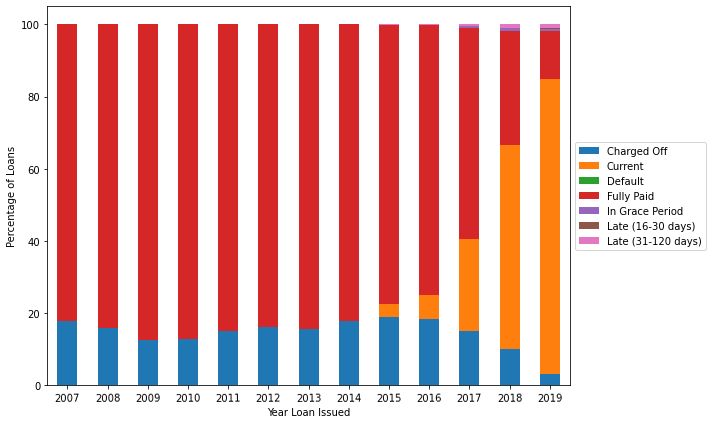

In [83]:
#Create a plot to show loan status by year.
data = pd.crosstab(dfFullLoans['issue_d_year'], dfFullLoans['loan_status'], normalize='index')
data = (data*100)
data.plot(kind='bar', stacked=True, rot=1,
          figsize=(10, 6)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Year Loan Issued')
plt.ylabel('Percentage of Loans')
plt.tight_layout()

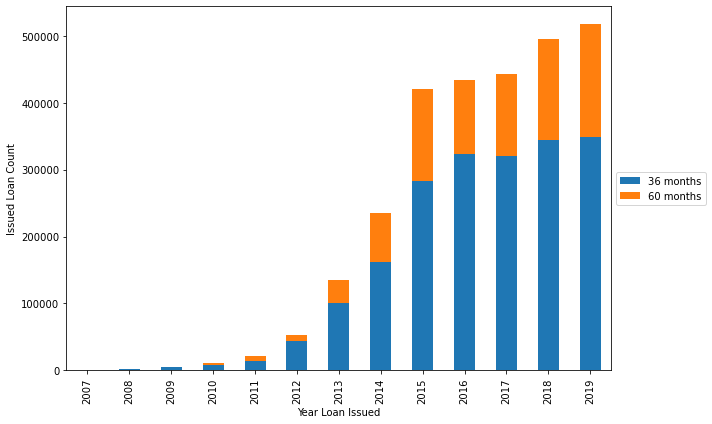

In [88]:
#Stacked bar chart to show loan growth from the start, broken down by loan term.
dfFullLoans.groupby(['issue_d_year', 'term'], observed=True).size().unstack().plot(kind = 'bar', stacked = True,
                    figsize=(10, 6)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Year Loan Issued')
plt.ylabel('Issued Loan Count')
plt.tight_layout()

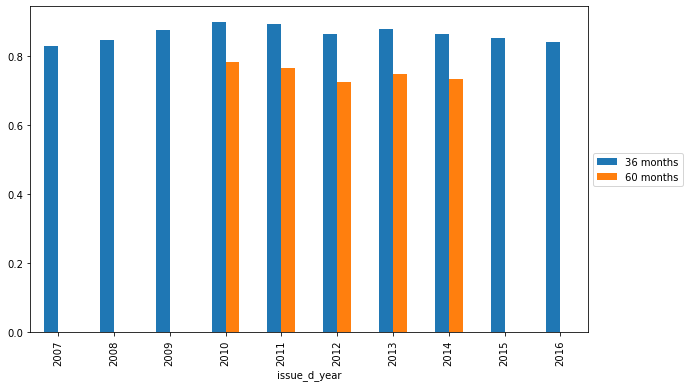

In [90]:
#Repayment rate by loan term and year.
group = dfPaidCharged[locLoans].groupby(['issue_d_year', 'term'], observed=True)['fully_paid']
pd.Series(group.sum().div(group.count())).unstack().plot(kind = 'bar', figsize=(10, 6)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

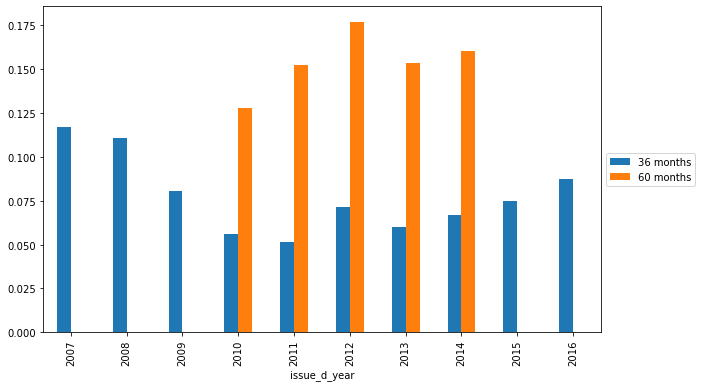

In [91]:
#Review what percent of principal is lost on a yearly basis by loan term.
group = dfPaidCharged[locLoans].groupby(['issue_d_year', 'term'], observed = True)
group['Loan_Loss'].sum().div(group['loan_amnt'].sum()).unstack().plot(kind = 'bar', figsize=(10, 6)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Loan Loss Dollars $

In [92]:
#Total loan amount in the dataframe.
sum(dfFinal.loan_amnt)

14371247000

In [93]:
group1 = dfFinal[dfFinal.loan_status=='Charged Off'].groupby('issue_d_year', observed=True)['Loan_Loss'].sum()
group1 = pd.Series(np.round(group1/1000000, 2), name = 'Loan Loss $s')

In [94]:
group2 = dfFinal.groupby('issue_d_year', observed=True)['loan_amnt'].sum()
group2 = pd.Series(np.round(group2/1000000,2), name = 'Total Loaned $s')

In [95]:
group3= np.round(group1.div(group2)*100,1)
group3 = pd.Series(group3, name = 'Loss % of Total')

In [96]:
#Loan Loss compared to loaned amount per year.
df = pd.DataFrame([group1, group2, group3]).T
df.index.name = 'Loan Issue Year'
df.index = df.index.astype('str')
df

,Loan Loss $s,Total Loaned $s,Loss % of Total
Loan Issue Year,,,
2007,0.25,2.11,11.8
2008,1.34,12.11,11.1
2009,3.71,46.10,8.0
2010,7.93,104.78,7.6
2011,24.32,246.62,9.9
2012,73.42,717.07,10.2
2013,185.42,1982.62,9.4
2014,369.79,3503.75,10.6
2015,270.83,3626.46,7.5


In [97]:
#Overall loan loss dollars and percent of total loaned amount.
dfSub = pd.DataFrame(columns=df.columns)
dfSub.loc['Total'] = [df.iloc[:,0].sum(), df.iloc[:,1].sum(), np.round(df.iloc[:,0].sum()/df.iloc[:,1].sum()*100,2)]
dfSub

,Loan Loss $s,Total Loaned $s,Loss % of Total
Total,1297.15,14371.25,9.03


In [98]:
#Combining the yearly loan loss data with the overall.
df.append(dfSub)

,Loan Loss $s,Total Loaned $s,Loss % of Total
2007,0.25,2.11,11.80
2008,1.34,12.11,11.10
2009,3.71,46.10,8.00
2010,7.93,104.78,7.60
2011,24.32,246.62,9.90
2012,73.42,717.07,10.20
2013,185.42,1982.62,9.40
2014,369.79,3503.75,10.60
2015,270.83,3626.46,7.50
2016,360.14,4129.63,8.70


### Review repayment of principal amount.

Text(0.5, 0, 'Percent %')

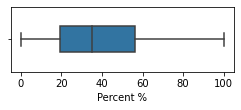

In [99]:
#Plot the percent of loan principal repaid.
df = dfFinal[dfFinal.loan_status =='Charged Off']
fig, axs = plt.subplots(figsize=(4,1.2))
axs = sns.boxplot((df.total_rec_prncp / df.loan_amnt)*100, width = 0.4, ax=axs)
axs.set_xlabel('Percent %')

In [100]:
#Average percentage of loan principal that is repaid through installment payments.
(df.total_rec_prncp / df.loan_amnt).mean()

0.3900662803036394

In [184]:
principleRate = pd.Series(dfFinal.total_rec_prncp / dfFinal.loan_amnt, name = 'rate')
loanStatus = dfFinal.loan_status
loanGrades = dfFinal.grade

In [185]:
dfRateSatus = pd.concat([principleRate, loanStatus, loanGrades], axis=1)

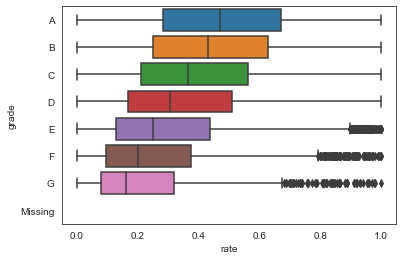

In [188]:
#Repaid principal % for charged off loans only, broken down by grade.
sns.boxplot(data = dfRateSatus[dfRateSatus.loan_status == 'Charged Off'], x='rate', y = 'grade')

### Review loan loss.

In [101]:
#Average loan loss.
dfFinal[dfFinal.loan_status=='Charged Off'].Loan_Loss.mean()

7617.794416107792

Text(0.5, 0, 'Loan Loss $')

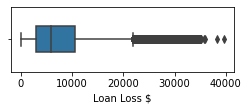

In [103]:
#Plot the loan losses using boxplot.
df = dfFinal[dfFinal.loan_status=='Charged Off'].Loan_Loss
fig, axs = plt.subplots(figsize=(4,1.2))
axs = sns.boxplot(df, width = 0.4, ax=axs)
axs.set_xlabel('Loan Loss $')

In [104]:
#Maximum amount recorded as a loan loss.
dfFinal[dfFinal.loan_status=='Charged Off'].Loan_Loss.max()

39589.35

# Calculating error cost to use in modelling.

In [105]:
dfFinal[dfFinal.charged_off==1].Loan_Loss.describe()

count    170278.000000
mean       7617.794416
std        6121.654481
min           0.000000
25%        3040.602250
50%        5906.535450
75%       10556.023800
max       39589.350000
Name: Loan_Loss, dtype: float64

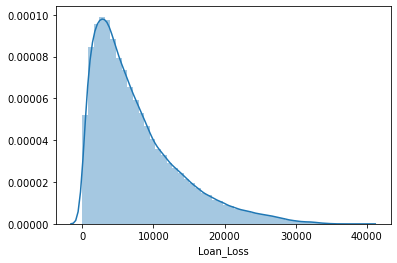

In [107]:
sns.distplot(dfFinal[dfFinal.charged_off==1].Loan_Loss)

In [106]:
dfFinal[dfFinal.charged_off==0].total_rec_int.describe()

count    898020.000000
mean       2412.457225
std        2628.240791
min           0.000000
25%         860.647500
50%        1597.125000
75%        2900.080000
max       28192.500000
Name: total_rec_int, dtype: float64

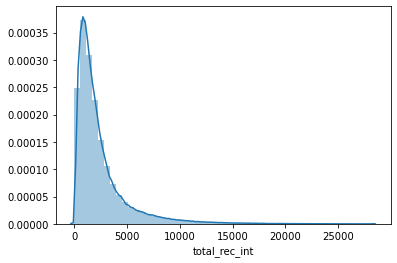

In [108]:
sns.distplot(dfFinal[dfFinal.charged_off==0].total_rec_int)

Cost of error used in modelling was based on the median values of loan loss on bad loans (\\$5906), and median value of interest received on good loans ($1597). This results in a cost ratio of 1:3.7 between good and bad. 

# Various Plots - some used in EDA, but not all

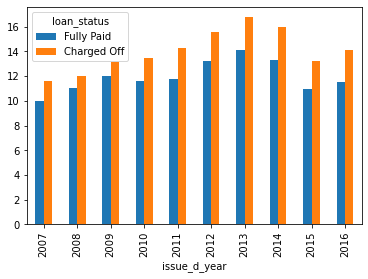

In [109]:
#Compare interest rate by year between good and bad loans.
group = dfFinal.groupby(['issue_d_year', 'loan_status'], observed=True)['int_rate'].mean()
group.unstack().plot(kind = 'bar')

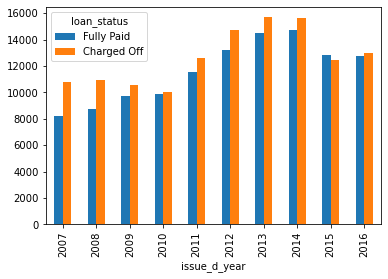

In [110]:
#Compare installment paymensts by year between good and bad loans.
group = dfFinal.groupby(['issue_d_year', 'loan_status'], observed=True)['loan_amnt'].mean()
group.unstack().plot(kind = 'bar')

In [111]:
#Removes the 'Missing' values so that it doesn't show up in charts as there are no instances with it for this feature.
dfFinal['loan_status'] = dfFinal['loan_status'].cat.remove_unused_categories()

Text(0.5, 1.0, '60 Months Loans')

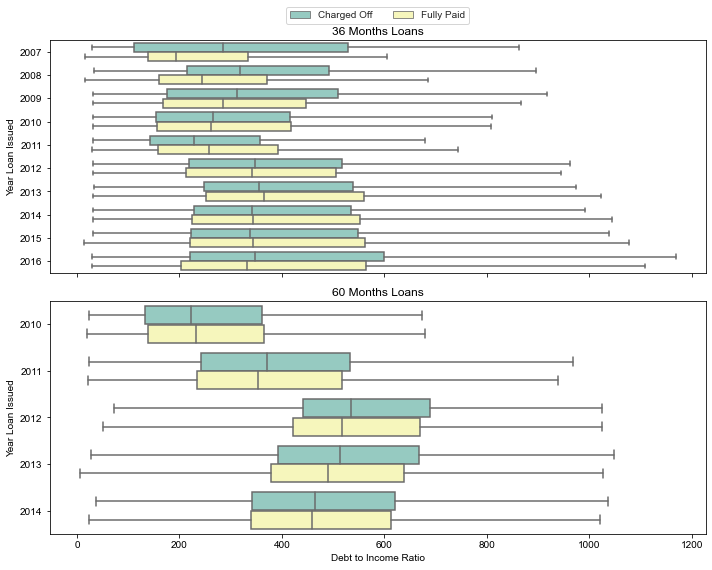

In [112]:
#DTI comparison across years, broken by term.
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(10,8))

sns.set_style("white")
ax0 = sns.boxplot(y=dfFinal[dfFinal.term_numeric ==36]["issue_d_year"].cat.remove_unused_categories(),
                 x="installment", hue=dfFinal[dfFinal.term_numeric ==36]['loan_status'].cat.remove_unused_categories(), data=dfFinal[dfFinal.term_numeric ==36], palette="Set3",
               ax=axs[0], showfliers =False, orient = 'h')

ax0.xaxis.label.set_visible(False)

ax2 = sns.boxplot(y=dfFinal[dfFinal.term_numeric ==60]["issue_d_year"].cat.remove_unused_categories(),
                 x="installment", hue=dfFinal[dfFinal.term_numeric ==60]['loan_status'].cat.remove_unused_categories(), data=dfFinal[dfFinal.term_numeric ==60], palette="Set3",
               ax=axs[1], showfliers =False, orient = 'h')


handles, labels = ax0.get_legend_handles_labels()
ax2.get_legend().remove()

ax0.legend(bbox_to_anchor=(0, 1.05, 1, 0.2), loc="lower center",
               ncol=2)

ax2.set_xlabel('Debt to Income Ratio')
ax2.set_ylabel('Year Loan Issued')
ax0.set_ylabel('Year Loan Issued')
ax0.set_title('36 Months Loans')
ax2.set_title('60 Months Loans')


Text(0.5, 0, 'Debt to Income Ratio')

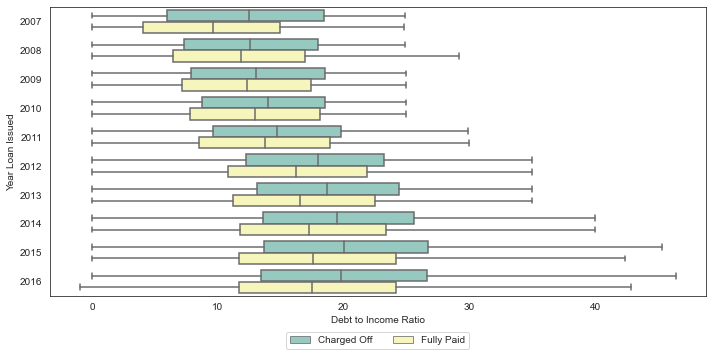

In [113]:
#DTI comparison across years.
fig, axs = plt.subplots(sharex=True, tight_layout=True, figsize=(10,5))

sns.set_style("white")
ax0 = sns.boxplot(y=dfFinal["issue_d_year"].cat.remove_unused_categories(),
                 x="dti", hue="loan_status", data=dfFinal, palette="Set3",
               ax=axs, showfliers =False, orient = 'h')

handles, labels = axs.get_legend_handles_labels()


ax0.legend(bbox_to_anchor=(0, -0.2, 1, 0.2), loc="lower center",
               ncol=2)


ax0.set_ylabel('Year Loan Issued')
axs.set_xlabel('Debt to Income Ratio')



Text(0.5, 0, 'Loan Interest Rate %')

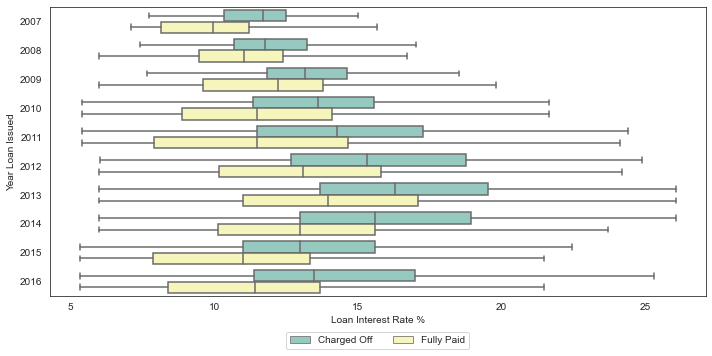

In [114]:
#Int rate comparison across years.
fig, axs = plt.subplots(sharex=True, tight_layout=True, figsize=(10,5))

sns.set_style("white")
ax0 = sns.boxplot(y=dfFinal["issue_d_year"].cat.remove_unused_categories(),
                 x="int_rate", hue="loan_status", data=dfFinal, palette="Set3",
               ax=axs, showfliers =False, orient = 'h')

handles, labels = axs.get_legend_handles_labels()


ax0.legend(bbox_to_anchor=(0, -0.2, 1, 0.2), loc="lower center",
               ncol=2)


ax0.set_ylabel('Year Loan Issued')
axs.set_xlabel('Loan Interest Rate %')



Text(0.5, 0, 'Annual Income (10,000s)')

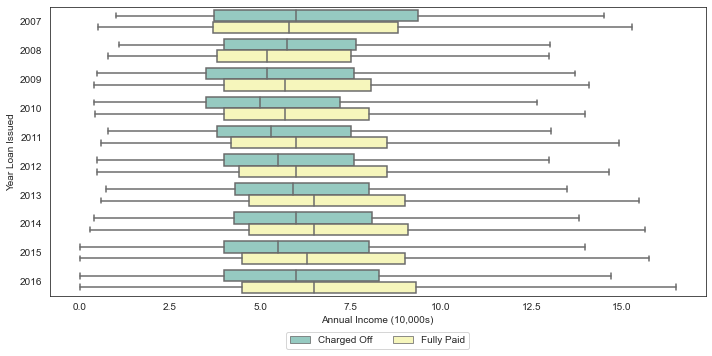

In [115]:
#Annual income comparison across years.
fig, axs = plt.subplots(sharex=True, tight_layout=True, figsize=(10,5))

sns.set_style("white")
ax0 = sns.boxplot(y=dfFinal["issue_d_year"].cat.remove_unused_categories(),
                 x="annual_inc", hue="loan_status", data=dfFinal, palette="Set3",
               ax=axs, showfliers =False, orient = 'h')

handles, labels = axs.get_legend_handles_labels()


ax0.legend(bbox_to_anchor=(0, -0.2, 1, 0.2), loc="lower center",
               ncol=2)


ax0.set_ylabel('Year Loan Issued')
axs.set_xlabel('Annual Income (10,000s)')



Text(0.5, 0, 'Loan Amount $')

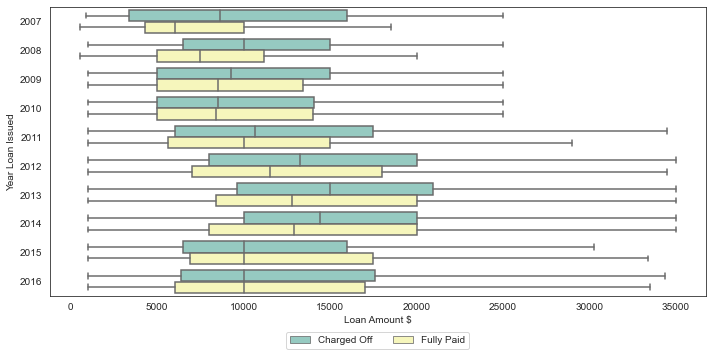

In [116]:
#Loan amount comparison across years.
fig, axs = plt.subplots(sharex=True, tight_layout=True, figsize=(10,5))

sns.set_style("white")
ax0 = sns.boxplot(y=dfFinal["issue_d_year"].cat.remove_unused_categories(),
                 x="loan_amnt", hue="loan_status", data=dfFinal, palette="Set3",
               ax=axs, showfliers =False, orient = 'h')

handles, labels = axs.get_legend_handles_labels()


ax0.legend(bbox_to_anchor=(0, -0.2, 1, 0.2), loc="lower center",
               ncol=2)


ax0.set_ylabel('Year Loan Issued')
axs.set_xlabel('Loan Amount $')



Text(0, 0.5, 'Loan Grade')

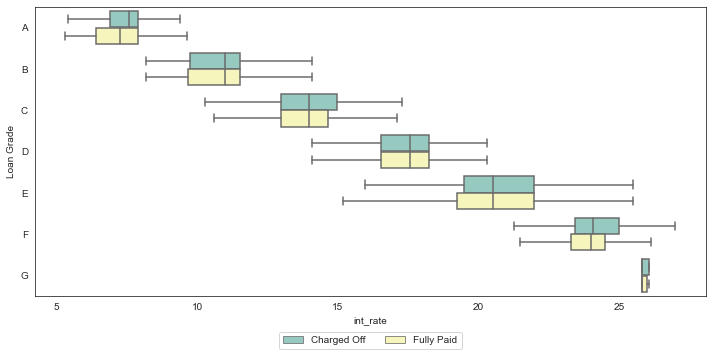

In [117]:
#Int rate comparison across loan grades.
fig, axs = plt.subplots(sharex=True, tight_layout=True, figsize=(10,5))

sns.set_style("white")
ax0 = sns.boxplot(y=dfFinal["grade"].cat.remove_unused_categories(),
                 x="int_rate", hue="loan_status", data=dfFinal, palette="Set3",
               ax=axs, showfliers =False, orient = 'h')

handles, labels = axs.get_legend_handles_labels()


ax0.legend(bbox_to_anchor=(0, -0.2, 1, 0.2), loc="lower center",
               ncol=2)


ax0.set_ylabel('Loan Grade')



Text(0, 0.5, 'Loan Grade')

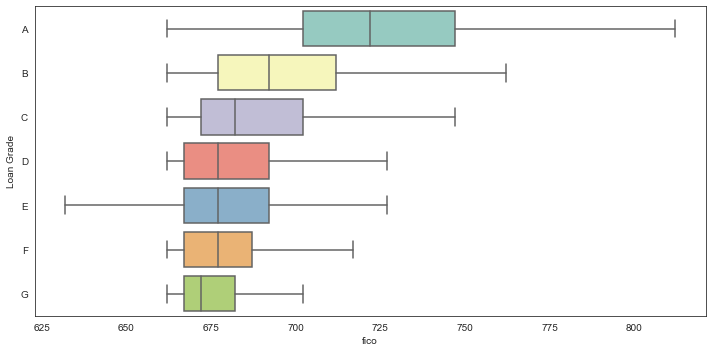

In [121]:
#Fico score comparison across loan grades.
fig, axs = plt.subplots(sharex=True, tight_layout=True, figsize=(10,5))

sns.set_style("white")
data = dfFinal
ax0 = sns.boxplot(y=data["grade"].cat.remove_unused_categories(),
                 x="fico", data=data, palette="Set3",
               ax=axs, showfliers =False, orient = 'h')

ax0.set_ylabel('Loan Grade')



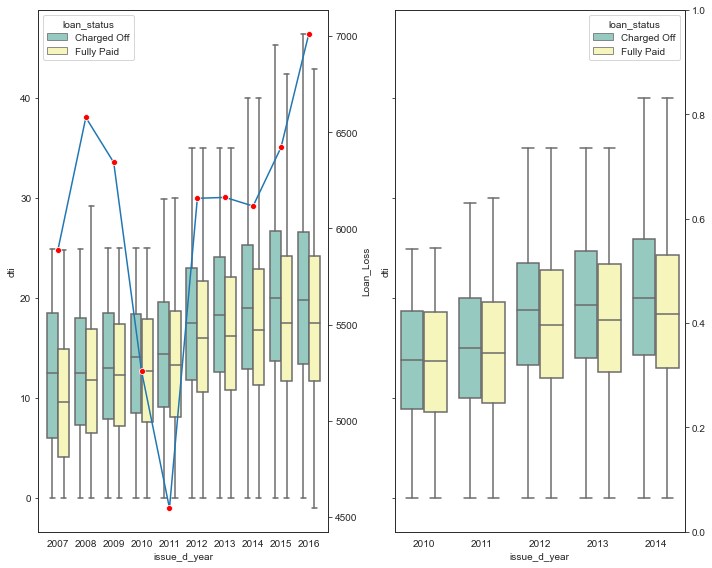

In [122]:
#Experimental/unfinished.
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(10,8))

sns.set_style("white")
ax0 = sns.boxplot(x=dfFinal[dfFinal.term_numeric ==36]["issue_d_year"].cat.remove_unused_categories(),
                 y="dti", hue="loan_status", data=dfFinal[dfFinal.term_numeric ==36], palette="Set3",
               ax=axs[0], showfliers =False)

ax1 = ax0.twinx()
data1 = dfFinal[(dfFinal.term_numeric == 36) & (dfFinal.loan_status=='Charged Off')].groupby(['issue_d_year'], observed=True)['Loan_Loss'].mean().reset_index()
sns.lineplot(x = 'issue_d_year', y = 'Loan_Loss', data = data1, ax=ax1, marker = 'o', markerfacecolor = 'red')


ax2 = sns.boxplot(x=dfFinal[dfFinal.term_numeric ==60]["issue_d_year"].cat.remove_unused_categories(),
                 y="dti", hue="loan_status", data=dfFinal[dfFinal.term_numeric ==60], palette="Set3",
               ax=axs[1], showfliers =False)



## Feature Analysis

### Numeric

In [126]:
columsNumeric = loanColumnsNumeric + borrowerCreditHistColumnsNumeric + instalColumnsNumeric + revColumnsNumeric + bankCardColumnsNumeric + tradesAccColumnsNumeric

In [127]:
columsNumeric.sort()

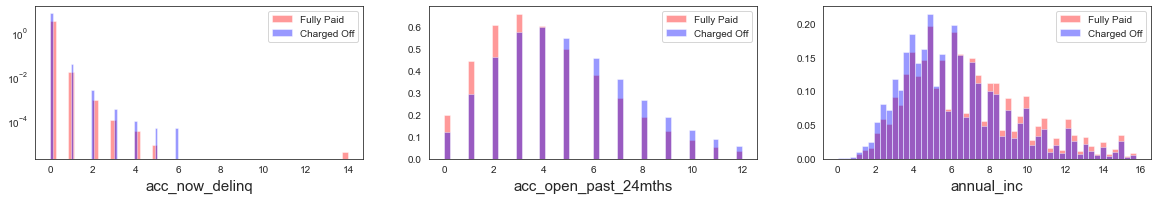

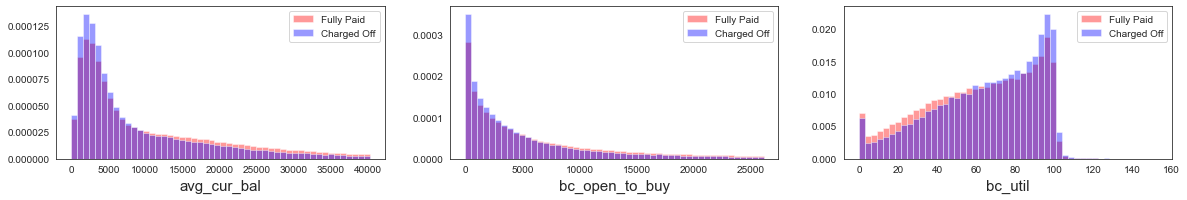

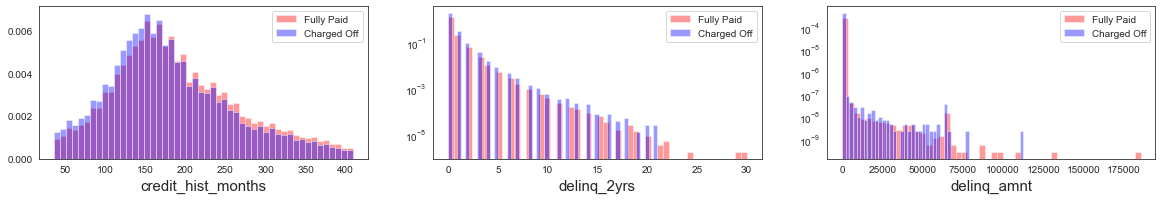

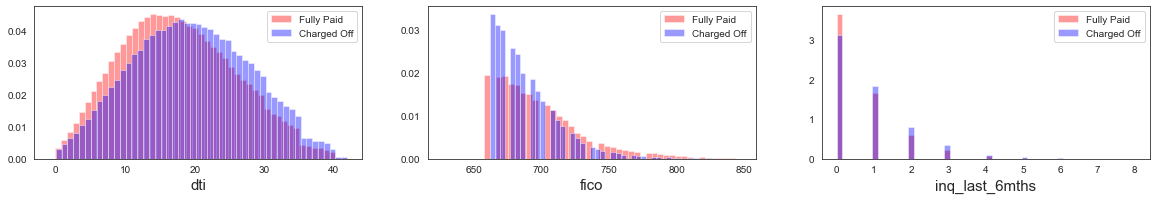

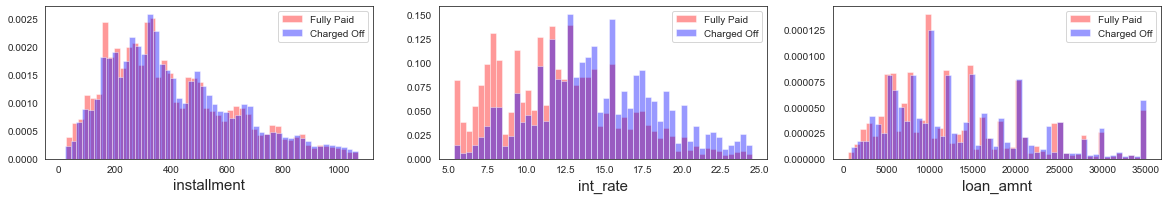

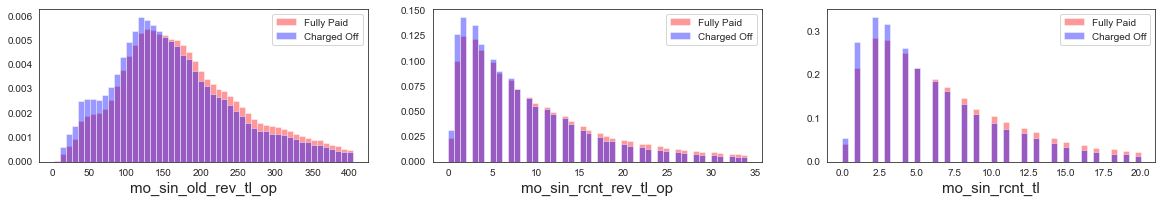

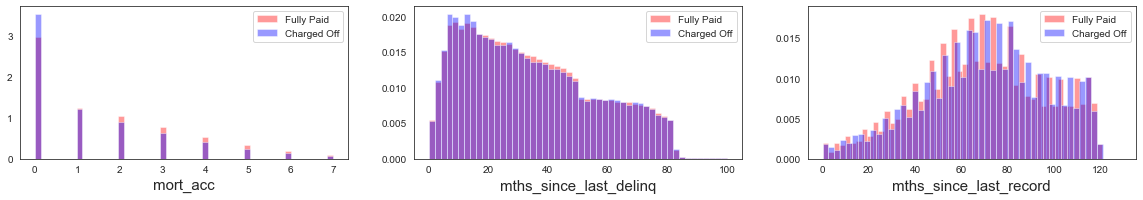

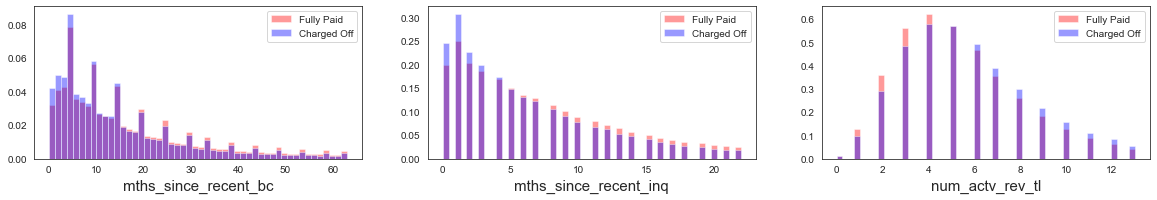

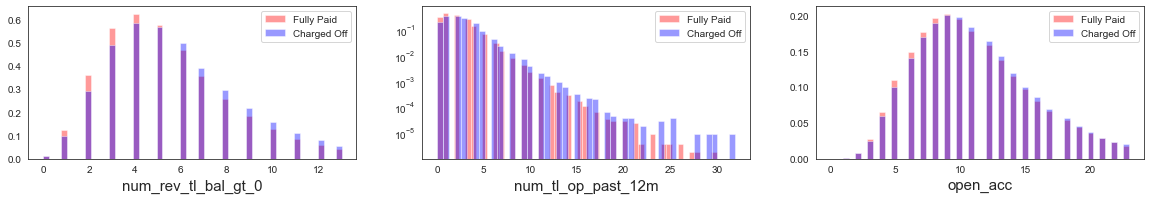

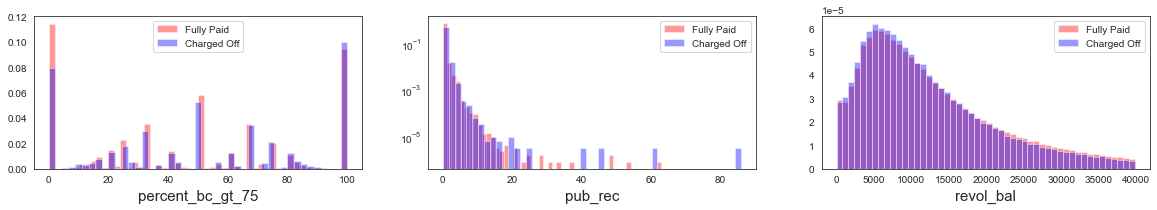

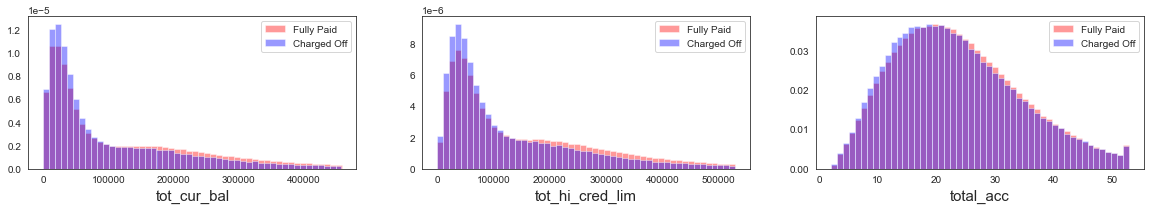

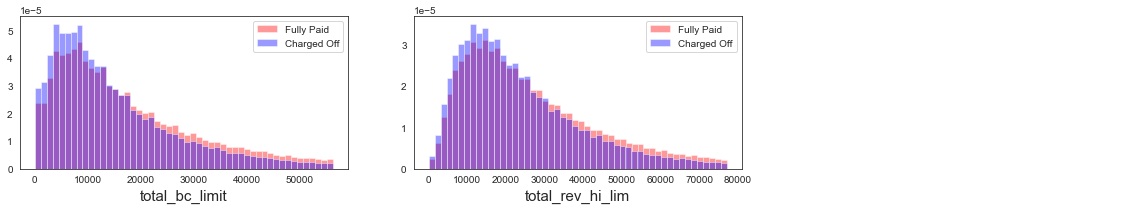

In [128]:
#Density plots for all selected numeric features broken down by loan status.
numericRelFreq2(dfFinal, columsNumeric)

In [147]:
#Numeric features descriptive statistics and statistical test for mean difference and correlation.
descStat(dfFinal, columsNumeric)

,Mean-FP,Mean-CO,Std-FP,Std-CO,Welch's t-stat.,ES-Cohen's D,Point Biserial Corr,Point B. P-val.
acc_now_delinq,0.0,0.0,0.1,0.1,2.34**,0.01,-0.00,0.015**
acc_open_past_24mths,4.3,5.2,3.0,3.3,96.34***,0.28,-0.10,0.0***
annual_inc,7.6,6.8,6.6,7.0,-45.27***,-0.12,0.05,0.0***
avg_cur_bal,13427.5,10350.6,16486.5,12925.6,-83.28***,-0.19,0.07,0.0***
bc_open_to_buy,9852.2,6843.1,15023.0,10911.0,-95.12***,-0.21,0.08,0.0***
bc_util,61.2,65.2,27.6,26.9,55.48***,0.15,-0.05,0.0***
credit_hist_months,199.3,189.5,92.6,91.5,-40.47***,-0.11,0.04,0.0***
delinq_2yrs,0.3,0.4,0.9,0.9,13.11***,0.04,-0.01,0.0***
delinq_amnt,14.6,20.6,787.5,937.3,2.46**,0.01,-0.00,0.006***
dti,17.7,19.6,8.7,9.9,74.47***,0.21,-0.08,0.0***


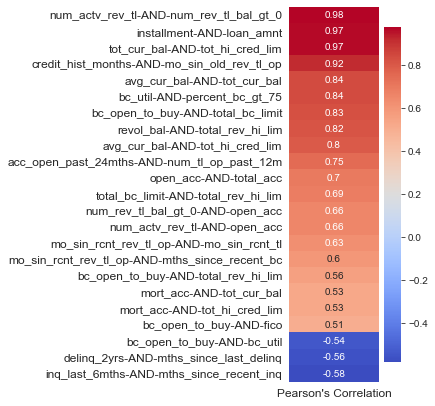

In [129]:
#Pearson correlation for numeric feature pairs where the correlation value is in the interval [0.5,1.0].
numHeatMap2(dfFinal, columsNumeric, multiGroup=False)

In [130]:
#Count of missing values for numerical features.
dfFinal[columsNumeric].isna().sum()

acc_now_delinq                 0
acc_open_past_24mths       45401
annual_inc                     0
avg_cur_bal                65626
bc_open_to_buy             55965
bc_util                    56570
credit_hist_months             0
delinq_2yrs                    0
delinq_amnt                    0
dti                           43
fico                           0
inq_last_6mths                 0
installment                    0
int_rate                       0
loan_amnt                      0
mo_sin_old_rev_tl_op       65615
mo_sin_rcnt_rev_tl_op      65615
mo_sin_rcnt_tl             65614
mort_acc                   45401
mths_since_last_delinq    535247
mths_since_last_record    890963
mths_since_recent_bc       55244
mths_since_recent_inq     153875
num_actv_rev_tl            65614
num_rev_tl_bal_gt_0        65614
num_tl_op_past_12m         65614
open_acc                       0
percent_bc_gt_75           56358
pub_rec                        0
revol_bal                      0
tot_cur_ba

### Categorical - Loan Related

In [131]:
#Missing values for categorical features.
dfPaidCharged[loanColumnsNonNum].isna().sum()

term             0
grade            0
sub_grade        0
purpose          0
issue_d_month    0
issue_d_year     0
dtype: int64

### Term

In [148]:
#Obtaining locations where 36 and 60 month loans have data available from start to finish of each year.
locTerm = (dfFinal.issue_d_year >= '2011') & (dfFinal.issue_d_year <= '2014')

In [149]:
#Descriptive information based on loan term.
categoricalFeatTable(dfFinal[locTerm], 'term')

,Proportion of Loans %,Overall Bad Loan $ Loss %,Repayment %,Avg. Loan Amnt.,Avg. Loan Install.,Avg. Loan Int. Rate
term,,,,,,
36 months,72.04,39.19,86.87,12347.0,413.24,12.69
60 months,27.96,60.81,73.90,20044.0,501.54,17.05


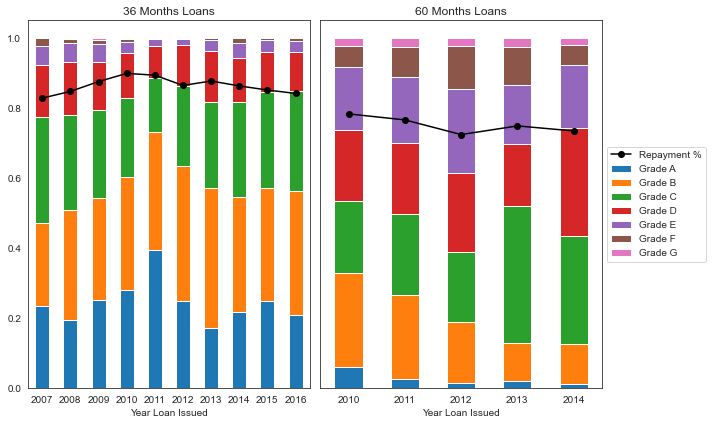

In [150]:
#Plot to show loan grade breakdown by year and term.
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)


#Grades - 36 months.
group = dfFinal[dfFinal.term_numeric == 36].groupby(['issue_d_year', 'grade'], observed=True).size()
group2 = dfFinal[dfFinal.term_numeric == 36].groupby(['issue_d_year'], observed=True).size()
ax0 = group.div(group2).unstack().plot(kind = 'bar', stacked = True, figsize=(10, 6), ax=axs[0], legend = False)

#Repayment - 36 months.
group3 = dfFinal[dfFinal.term_numeric==36].groupby('issue_d_year', observed=True)['fully_paid'].mean()
ax0 = group3.plot(linestyle = '-', marker = 'o', ax=axs[0], colormap='gray', label = 'Repayment %')
handles, labels = axs[0].get_legend_handles_labels()
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_title('36 Months Loans')
axs[0].set_xlabel('Year Loan Issued')

#Grades - 60 months.
group = dfFinal[dfFinal.term_numeric == 60].groupby(['issue_d_year', 'grade'], observed=True).size()
group2 = dfFinal[dfFinal.term_numeric == 60].groupby(['issue_d_year'], observed=True).size()
ax0 = group.div(group2).unstack().plot(kind = 'bar', stacked = True, figsize=(10, 6), ax=axs[1], legend = False)

#Repayment - 36 months.
group3 = dfFinal[dfFinal.term_numeric==60].groupby('issue_d_year', observed=True)['fully_paid'].mean()
ax0 = group3.plot(linestyle = '-', marker = 'o', ax=axs[1], colormap='gray', label = 'Repayment %')
handles, labels = axs[0].get_legend_handles_labels()
labels[1:] = ['Grade '+grade for grade in labels[1:]]
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].set_title('60 Months Loans')
axs[1].set_xlabel('Year Loan Issued')


plt.show()

### Grade

In [151]:
#Descriptive information based on loan grade.
gradeDF = categoricalFeatTable(dfFinal, 'grade')
gradeDF

,Proportion of Loans %,Overall Bad Loan $ Loss %,Repayment %,Avg. Loan Amnt.,Avg. Loan Install.,Avg. Loan Int. Rate
grade,,,,,,
A,19.78,5.50,94.44,13933.0,429.28,7.11
B,32.07,19.19,88.22,12610.0,401.01,10.69
C,27.53,30.57,81.00,13052.0,418.04,13.98
D,13.62,24.01,74.51,14058.0,456.57,17.49
E,5.09,13.72,67.90,15957.0,504.46,20.64
F,1.55,5.39,63.19,16970.0,532.37,23.96
G,0.36,1.62,57.90,19162.0,604.39,25.78


In [252]:
#Pearson correlation between rank of loan grade values and interest rate. Close to 1 indicates that
#they are essentially linked to one another.
pearsonr(dfFinal.grade.rank(), dfFinal.int_rate)

(0.9301841256435777, 0.0)

In [152]:
#Getting pearson correlation values between grade rank values and all numeric features.
resultList =[]
for col in columsNumeric:
    loc = dfFinal[col].notna()
    result = pearsonr(dfFinal.loc[loc, 'grade'].rank(), dfFinal.loc[loc, col])
    #print('Column {}, Pearson"s Correlation: {} p-value: {}'.format(col, result[0], result[1]))
    resultList.append((col, np.round(result[0],2), np.round(result[1], 2)))
resultDF = pd.DataFrame(resultList, columns = ['Feature', 'Corr.', 'p-value'])

In [153]:
resultDF.sort_values(['Corr.'])

,Feature,Corr.,p-value
10,fico,-0.45,0.0
4,bc_open_to_buy,-0.32,0.0
33,total_bc_limit,-0.28,0.0
34,total_rev_hi_lim,-0.19,0.0
22,mths_since_recent_inq,-0.18,0.0
31,tot_hi_cred_lim,-0.16,0.0
15,mo_sin_old_rev_tl_op,-0.16,0.0
6,credit_hist_months,-0.14,0.0
17,mo_sin_rcnt_tl,-0.13,0.0
30,tot_cur_bal,-0.12,0.0


Text(0.5, 0, 'FICO Score')

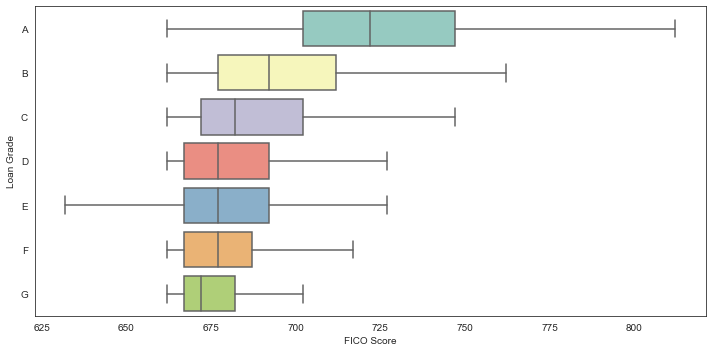

In [154]:
#Int rate comparison across years.
fig, axs = plt.subplots(sharex=True, tight_layout=True, figsize=(10,5))

sns.set_style("white")
ax0 = sns.boxplot(y=dfFinal["grade"].cat.remove_unused_categories(),
                 x="fico", data=dfFinal, palette="Set3",
               ax=axs, showfliers =False, orient = 'h')

handles, labels = axs.get_legend_handles_labels()

'''
ax0.legend(bbox_to_anchor=(0, -0.2, 1, 0.2), loc="lower center",
               ncol=2)
'''

ax0.set_ylabel('Loan Grade')
axs.set_xlabel('FICO Score')



In [155]:
#Propoertion of loans made up by first 3 grades - A to C.
gradeDF.iloc[0:3,0].sum()

79.38

In [156]:
#Proportion of bad loans from A to C.
gradeDF.iloc[0:3,1].sum()

55.260000000000005

### Purpose

In [158]:
#Number of different values under the purpose feature.
dfFinal.purpose.unique().shape

(14,)

In [159]:
#Descriptive information based on loan purpose.
purposeDF = categoricalFeatTable(dfFinal, 'purpose')
purposeDF.sort_index()

,Proportion of Loans %,Overall Bad Loan $ Loss %,Repayment %,Avg. Loan Amnt.,Avg. Loan Install.,Avg. Loan Int. Rate
purpose,,,,,,
car,1.14,0.57,87.57,8108.0,257.37,11.63
credit_card,22.79,18.69,86.61,14131.0,443.31,11.21
debt_consolidation,57.22,63.83,83.14,14228.0,451.45,12.88
educational,0.03,0.02,83.23,6636.0,216.59,11.63
home_improvement,6.25,5.74,85.88,12836.0,405.61,12.16
house,0.44,0.57,80.50,13887.0,455.68,15.41
major_purchase,2.17,1.75,85.71,10261.0,327.39,12.06
medical,1.15,0.86,82.03,8011.0,262.71,13.69
moving,0.74,0.53,80.38,7053.0,237.58,15.02


### Categorical - Borrower Related

In [160]:
#Categorical features which were considered as related to a borrower.
borrowerCreditHistColumnsNonNum

['emp_length',
 'home_ownership',
 'verification_status',
 'earliest_cr_line_month',
 'earliest_cr_line_year']

### emp_length

In [162]:
#All possible values under emp_length feature.
dfFinal.emp_length.unique()

[NaN, '6 years', '4 years', '10+ years', '7 years', ..., '1 year', '3 years', '9 years', '5 years', '8 years']
Length: 12
Categories (11, object): ['< 1 year' < '1 year' < '2 years' < '3 years' ... '7 years' < '8 years' < '9 years' < '10+ years']

In [163]:
#Percentage missing any indication of employment length.
naEmpLengthLoc = dfFinal.emp_length.isna()
naEmpLengthLoc.sum() / dfFinal.shape[0]

0.05936358581594274

In [164]:
#Adding the value Missing to loans with NaN for emp_length.
dfFinal.loc[naEmpLengthLoc, 'emp_length'] = 'Missing'

In [165]:
#Descriptive information based on emp_length.
categoricalFeatTable(dfFinal, 'emp_length')

,Proportion of Loans %,Overall Bad Loan $ Loss %,Repayment %,Avg. Loan Amnt.,Avg. Loan Install.,Avg. Loan Int. Rate
emp_length,,,,,,
< 1 year,7.90,7.81,83.70,12642.0,404.05,12.56
1 year,6.61,6.33,83.80,12519.0,400.99,12.61
2 years,9.07,8.60,84.35,12804.0,409.03,12.59
3 years,8.03,7.76,84.12,12941.0,413.52,12.58
4 years,5.97,5.79,84.26,13071.0,417.11,12.59
5 years,6.28,6.23,84.25,13214.0,420.49,12.66
6 years,4.77,4.92,84.08,13497.0,427.03,12.79
7 years,4.55,4.84,83.85,13704.0,430.75,12.84
8 years,4.70,4.93,84.01,13739.0,435.12,12.55


In [166]:
#Row locations where emp_length is Missing
loc = dfFinal.emp_length=='Missing'

In [167]:
#Checking mean of annual_inc for instances where emp_length is missing compared to those where it's not.
#Value is significantly less - could be due to retirees, social assistance, etc.
dfFinal[loc].annual_inc.mean()/dfFinal[~loc].annual_inc.mean()

0.6433155687142346

 ### verification_status

In [168]:
#Number of missing values for verification_status.
dfFinal.verification_status.isna().sum()

0

In [169]:
#Descriptive information based on verification_status.
categoricalFeatTable(dfFinal, 'verification_status')

,Proportion of Loans %,Overall Bad Loan $ Loss %,Repayment %,Avg. Loan Amnt.,Avg. Loan Install.,Avg. Loan Int. Rate
verification_status,,,,,,
Verified,31.83,44.18,80.93,15690.0,495.95,14.03
Source Verified,38.51,39.66,83.51,13645.0,431.01,12.52
Not Verified,29.66,16.16,88.13,10800.0,347.47,11.11


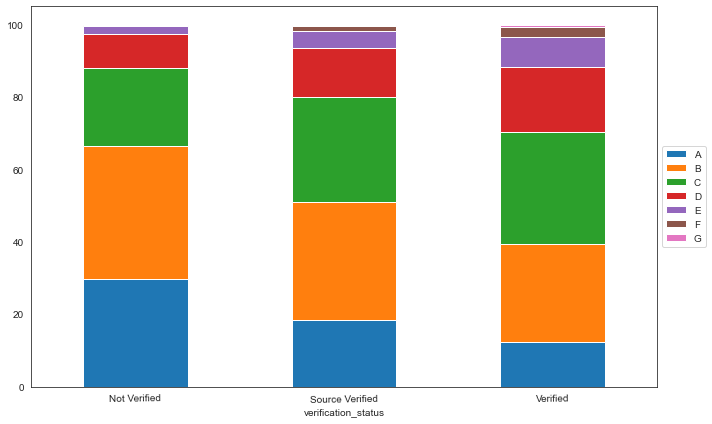

In [170]:
#Create a plot to show loan grade broken down by verification_status
data = pd.crosstab(dfFinal['verification_status'], dfFinal['grade'], normalize='index')
data = (data*100)
ax = data.plot(kind='bar', stacked=True, rot=1,
          figsize=(10, 6)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlabel('Year Loan Issued')
#plt.ylabel('Percentage of Loans')
plt.tight_layout()

### home_ownership

In [171]:
#Check for missing values.
dfFinal.home_ownership.isna().sum()

0

In [172]:
#Exclude certain home_ownership values.
location = dfFinal.home_ownership.isin(['NONE', 'OTHER', 'ANY'])

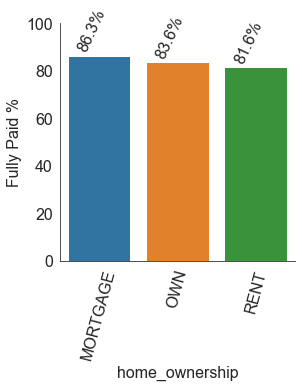

In [173]:
#Plot repayment rate based on home_ownership excluding the insignificant ones (NONE, OTHER, and ANY)
catPlot(dfFinal[~location], ['home_ownership'], sort=True)

In [174]:
#Descriptive information based on home_ownership.
categoricalFeatTable(dfFinal, 'home_ownership')

,Proportion of Loans %,Overall Bad Loan $ Loss %,Repayment %,Avg. Loan Amnt.,Avg. Loan Install.,Avg. Loan Int. Rate
home_ownership,,,,,,
MORTGAGE,47.86,46.73,86.33,15023.0,469.60,12.21
RENT,41.41,42.84,81.56,11788.0,381.05,13.02
OWN,10.70,10.41,83.59,12866.0,413.39,12.59
ANY,0.01,0.01,83.70,11349.0,378.84,12.14
OTHER,0.01,0.01,82.09,11726.0,391.13,13.22
NONE,0.00,0.00,84.44,14083.0,459.38,15.04


Text(0.5, 0, 'Int. Rate %')

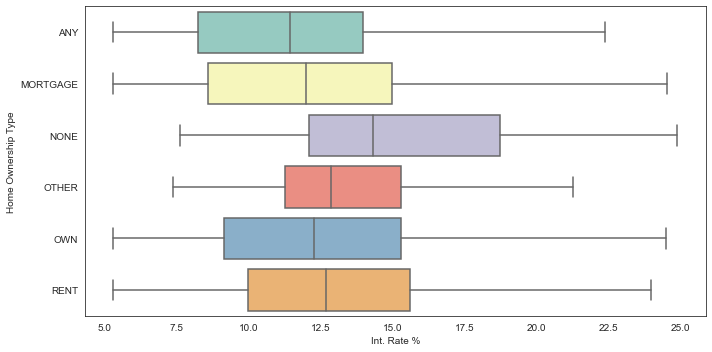

In [176]:
#Int rate comparison home ownership.
fig, axs = plt.subplots(sharex=True, tight_layout=True, figsize=(10,5))

sns.set_style("white")
ax0 = sns.boxplot(y=dfFinal["home_ownership"].cat.remove_unused_categories(),
                 x="int_rate", data=dfFinal, palette="Set3",
               ax=axs, showfliers =False, orient = 'h')

handles, labels = axs.get_legend_handles_labels()

'''
ax0.legend(bbox_to_anchor=(0, -0.2, 1, 0.2), loc="lower center",
               ncol=2)
'''

ax0.set_ylabel('Home Ownership Type')
axs.set_xlabel('Int. Rate %')



In [177]:
#Percent of loans where home_ownership is under ANY, OTHER, or NONE.
data = categoricalFeatTable(dfFinal, 'home_ownership')
data['Proportion of Loans %'].nsmallest(3).sum()

0.02

### Crammers V for categorical features

In [179]:
#Categorical features to calculate Crammer's V on.
crammerCol = ['emp_length', 'grade', 'home_ownership', 'loan_status', 'purpose', 'term', 'verification_status']

In [180]:
crammerDF = pd.DataFrame(index=crammerCol, columns=crammerCol, dtype='float')

In [181]:
for ind in crammerDF.index:
    for col in crammerDF.columns:
        result = cramers_v(dfFinal[ind], dfFinal[col])
        crammerDF.loc[ind,col] = result[0]

In [182]:
crammerDF.round(2)

,emp_length,grade,home_ownership,loan_status,purpose,term,verification_status
emp_length,1.00,0.01,0.10,0.04,0.02,0.07,0.13
grade,0.01,1.00,0.05,0.22,0.09,0.38,0.18
home_ownership,0.10,0.05,1.00,0.06,0.09,0.09,0.03
loan_status,0.04,0.22,0.06,1.00,0.05,0.10,0.08
purpose,0.02,0.09,0.09,0.05,1.00,0.07,0.06
term,0.07,0.38,0.09,0.10,0.07,1.00,0.18
verification_status,0.13,0.18,0.03,0.08,0.06,0.18,1.00


[Text(0, 0.5, 'emp_length'),
 Text(0, 1.5, 'grade'),
 Text(0, 2.5, 'home_ownership'),
 Text(0, 3.5, 'loan_status'),
 Text(0, 4.5, 'purpose'),
 Text(0, 5.5, 'term'),
 Text(0, 6.5, 'verification_status')]

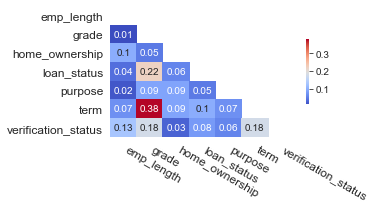

In [183]:
#Creating a heatmap from the calculated Crammer's V values.

fig, axs = plt.subplots(tight_layout=True, figsize=(5,3))


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(crammerDF.round(2), dtype=np.bool))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
axs = sns.heatmap(crammerDF.round(2), mask=mask, cmap="coolwarm",
          linewidths=0, cbar_kws={"shrink": .5}, annot=True, fmt="g", ax=axs)

axs.xaxis.set_ticklabels(axs.get_xmajorticklabels(),fontsize = 12, rotation = -30, ha = 'left')
axs.yaxis.set_ticklabels(axs.get_ymajorticklabels(),fontsize = 12)

